In [1]:

import sys
sys.path.append('../')
from fit.datamodules.super_res import MNIST_SResFITDM
from fit.utils.tomo_utils import get_polar_rfft_coords_2D

from fit.modules.SResTransformerModule import SResTransformerModule

from matplotlib import pyplot as plt
from matplotlib import gridspec
from fit.transformers.PSNR import RangeInvariantPsnr as PSNR
# from fit.utils.utils import PSNR
import torch

import numpy as np
import pandas as pd
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger

from os.path import exists
import wget
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import scipy

/localscratch/miniforge3/envs/FIT_LS/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/localscratch/miniforge3/envs/FIT_LS/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/localscratch/miniforge3/envs/FIT_LS/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed_everything(22122020)

Seed set to 22122020


22122020

In [3]:
dm = MNIST_SResFITDM(root_dir='./datamodules/data/', batch_size=32)
dm.prepare_data(subset_flag=False)
dm.setup()

In [4]:
r, phi, flatten_order, order = get_polar_rfft_coords_2D(img_shape=dm.gt_shape)

In [5]:
n_heads = 8
d_query = 32

In [14]:
model = SResTransformerModule(d_model=n_heads*d_query, 
                              img_shape=dm.gt_shape,
                              coords=(r, phi),
                              dst_flatten_order=flatten_order,
                              dst_order=order,
                              loss='prod',
                              lr=0.0001, weight_decay=0.01, n_layers=8,
                              n_heads=n_heads, d_query=d_query, dropout=0.1, attention_dropout=0.1,num_shells = 5,model_path = '')

model.load_test_model('/home/aman.kukde/Projects/FourierImageTransformer/models_saved/15-03_09-43-37_prod_modified_+branch_main_Full_dataset_Train/epoch=0-step=1719.ckpt')
# model.cuda()
tokeniser_weights = torch.load('/home/aman.kukde/Projects/FourierImageTransformer/model.ckpt')['state_dict']
for key in list(tokeniser_weights.keys()):
    if '.encoder' in key:
        del tokeniser_weights[key]

def load_partial_state_dict(model, state_dict):
    own_state = model.state_dict()
    for name, param in state_dict.items():
        if name in own_state:
            print(f'Copying {name}')
            if own_state[name].size() == param.size():
                own_state[name].copy_(param)
                own_state[name].requires_grad = False
                own_state[name].training = False
        # else:
        #     print(f'Layer {name} not found in current model')
    model.load_state_dict(tokeniser_weights, strict=False)
    return model

model = load_partial_state_dict(model, tokeniser_weights)

trainer = Trainer(max_epochs=100, 
                  #gpus=1, # set to 0 if you want to run on CPU
                  callbacks=ModelCheckpoint(
                                            dirpath=None,
                                            save_top_k=1,
                                            verbose=False,
                                            save_last=True,
                                            monitor='Validation/avg_val_loss',
                                            mode='min'
                                        ), 
                  deterministic=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Copying sres.fourier_coefficient_embedding.weight
Copying sres.fourier_coefficient_embedding.bias
Copying sres.predictor_amp.weight
Copying sres.predictor_amp.bias
Copying sres.predictor_phase.weight
Copying sres.predictor_phase.bias


In [15]:
for fc, (mag_min, mag_max) in dm.test_dataloader():
    break

In [8]:
# for fc, (mag_min, mag_max) in dm.train_dataloader():
#     break

In [30]:
fc = fc.to('cuda')
mag_min = mag_min.to('cuda')
mag_max = mag_max.to('cuda')
x_fc = fc[:, flatten_order][:, :96]
pred = model.sres.forward_i(x_fc,96)
# pred[:,96:] = (pred[:,96:] - pred[:,96:].min()) / (pred[:,96:].max() - pred[:,96:].min())
pred_img = model.convert2img(fc=pred, mag_min=mag_min, mag_max=mag_max)

                    

In [31]:
lowres = torch.zeros_like(pred)
# lowres += fc.min()
lowres[:, :model.input_seq_length] = fc[:, model.dst_flatten_order][:, :model.input_seq_length]
lowres_img = model.convert2img(fc=lowres, mag_min=mag_min, mag_max=mag_max)
gt_img = model.convert2img(fc=fc[:, model.dst_flatten_order], mag_min=mag_min, mag_max=mag_max)

lowres_psnr = PSNR(gt_img,lowres_img)
pred_psnr = PSNR(gt_img,pred_img)
                    

In [38]:
low = []
pred = []
low.append(PSNR(gt_img,lowres_img))
pred.append(PSNR(gt_img,pred_img))

In [42]:
pred_img.shape

torch.Size([32, 27, 27])

In [44]:
torch.cat(low, dim=0)


tensor([16.4783, 15.6369, 18.5643, 16.6600, 15.6753, 19.1677, 15.8290, 16.9459,
        16.3548, 16.0756, 14.9987, 14.6507, 16.3642, 15.6979, 18.3508, 14.5824,
        15.3373, 16.6705, 15.2279, 16.7732, 17.2731, 16.3728, 15.1735, 15.6795,
        16.8319, 16.9548, 16.5375, 16.2832, 15.9870, 18.3812, 16.5686, 18.2251],
       device='cuda:0')

In [46]:
torch.cat(pred, dim=0) - torch.cat(low, dim=0)

tensor([ 3.6057,  3.6354,  3.5211,  0.7508,  3.0071,  2.4120,  3.2589,  2.8572,
         2.4279,  2.5826,  3.3596,  3.0691,  2.5770,  2.4438,  2.0678,  3.0929,
         2.9935,  3.2192,  3.3492,  2.5387,  1.0896,  2.8795,  2.8358,  3.5191,
         1.8503, -0.4705,  3.2335,  3.0266,  1.2555,  3.4436,  3.3927,  2.1980],
       device='cuda:0')

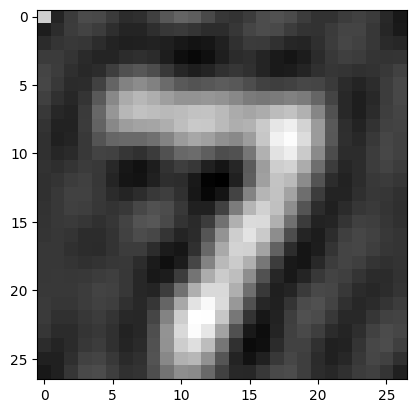

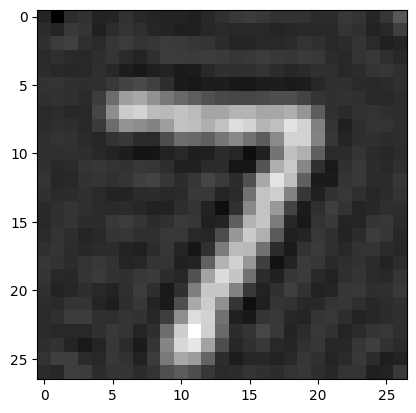

In [20]:
plt.imshow(lowres_img[0].cpu(), cmap='gray')
plt.show()
plt.imshow(pred_img[0].cpu(), cmap='gray')

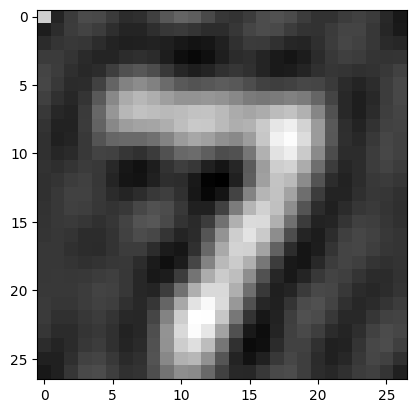

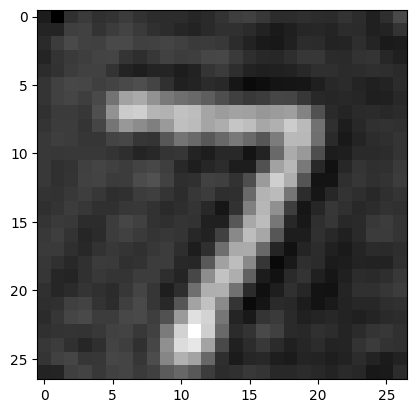

In [34]:
plt.imshow(lowres_img[0].cpu(), cmap='gray')
plt.show()
plt.imshow(pred_img[0].cpu(), cmap='gray')

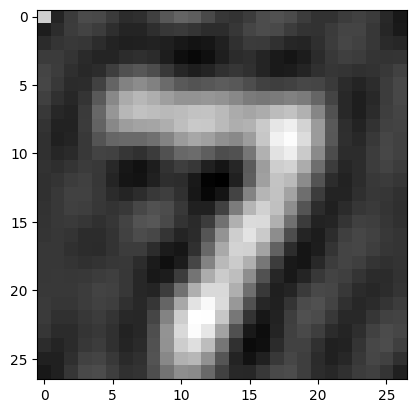

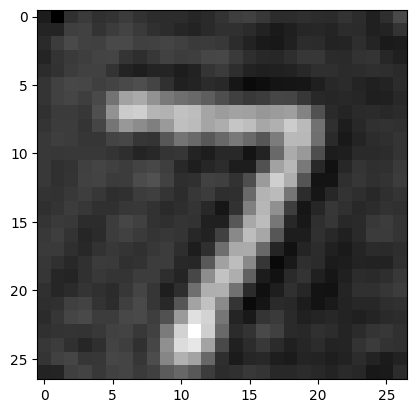

In [35]:
plt.imshow(lowres_img[0].cpu(), cmap='gray')
plt.show()
plt.imshow(pred_img[0].cpu(), cmap='gray')

In [22]:
for i in [pred_img, lowres_img, gt_img]:
    i.cpu().detach().numpy()

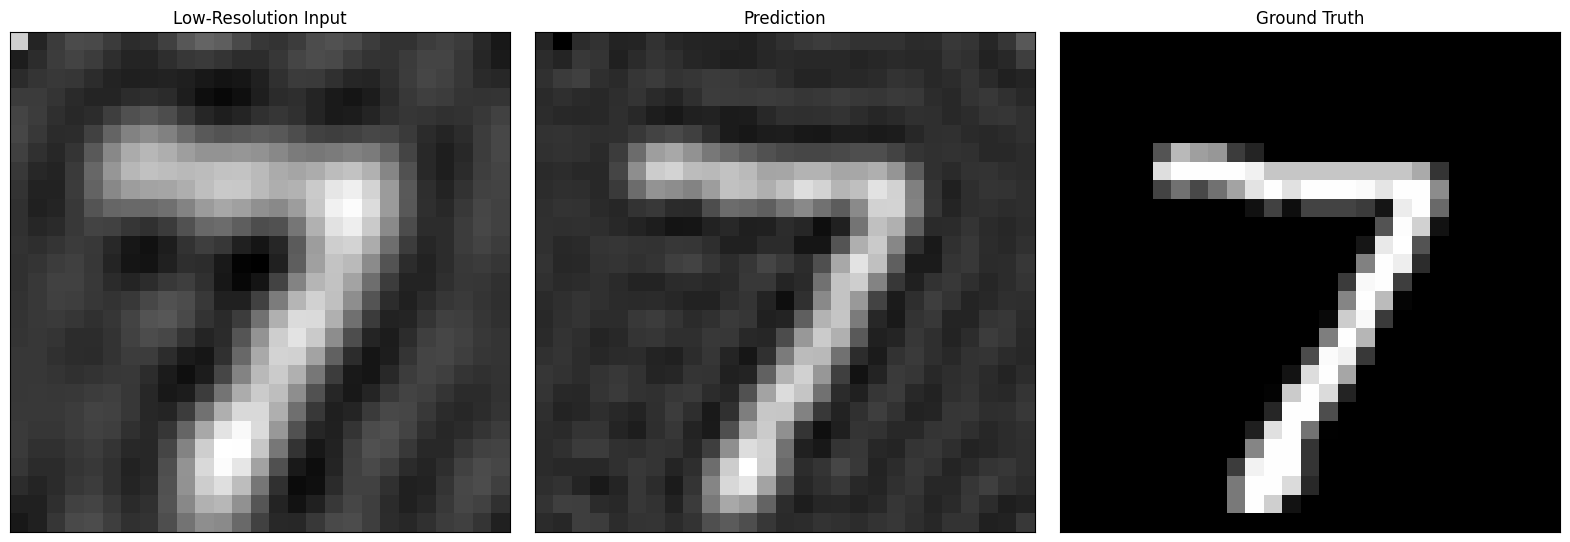

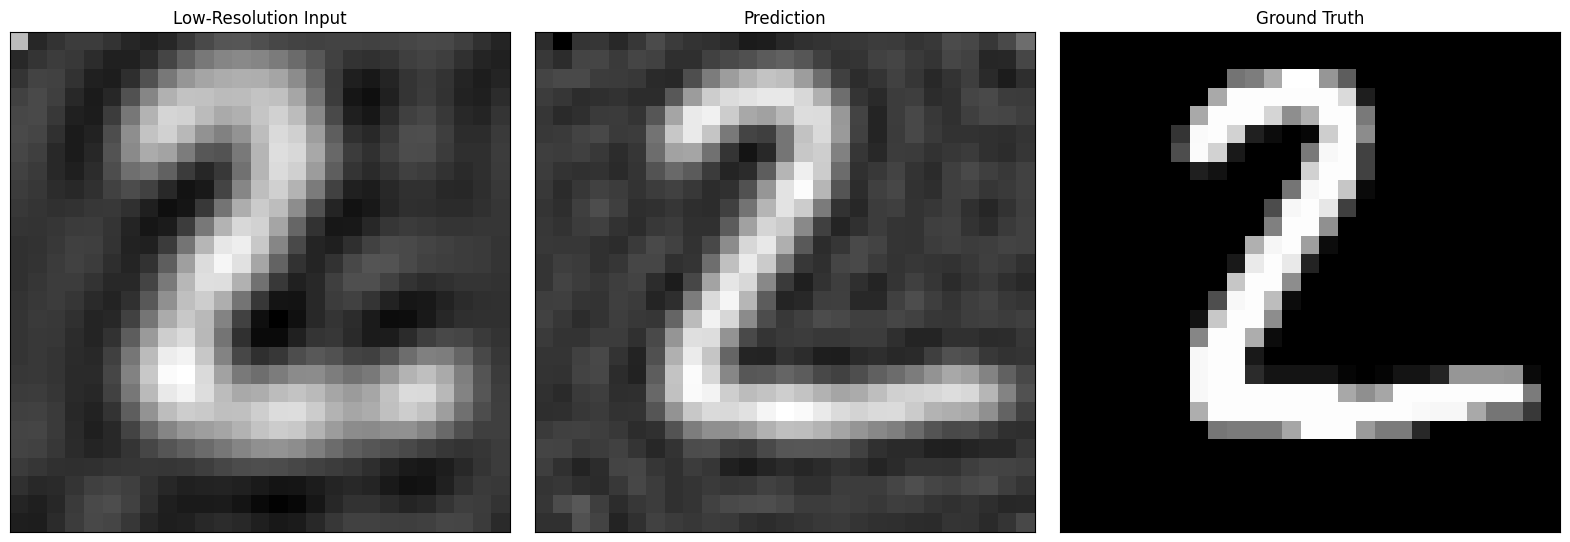

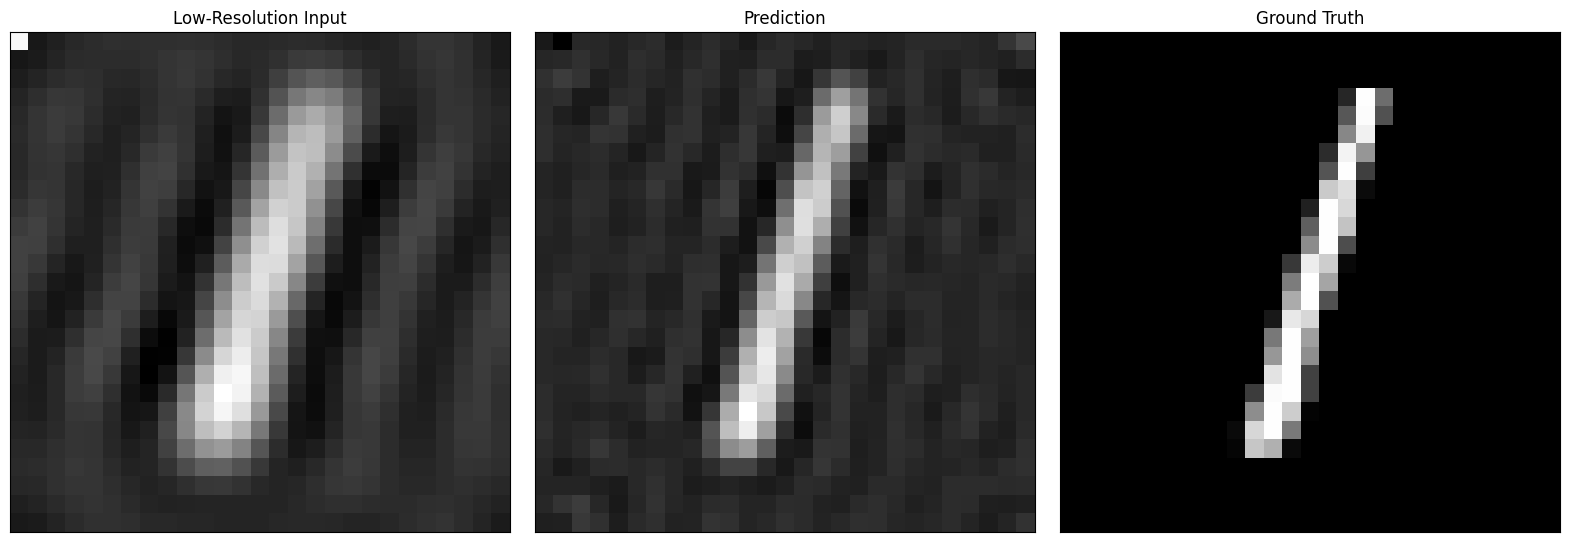

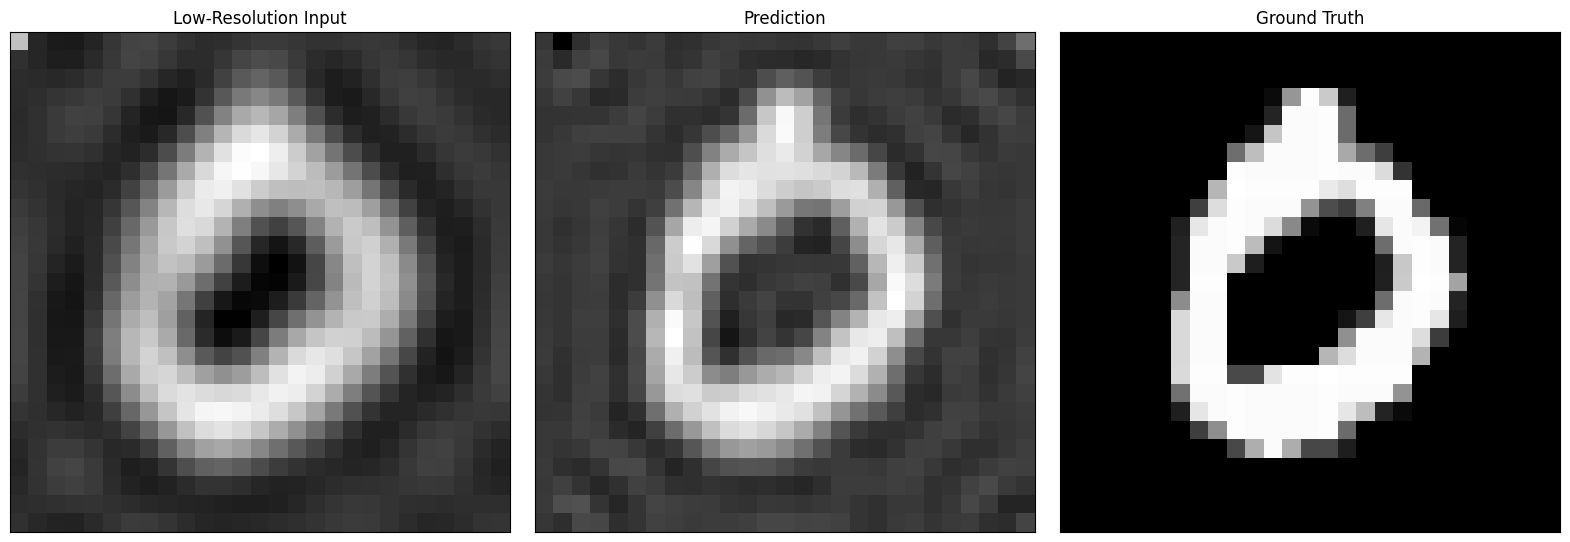

In [23]:
for sample in range(4):
    fig = plt.figure(figsize=(31/2., 10/2.)) 
    gs = gridspec.GridSpec(1, 5, width_ratios=[10,0.5, 10, 0.5, 10]) 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[2])
    ax2 = plt.subplot(gs[4])
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                        hspace = 0, wspace = 0)

    ax0.xaxis.set_major_locator(plt.NullLocator())
    ax0.yaxis.set_major_locator(plt.NullLocator())
    ax0.imshow(lowres_img[sample].cpu(), cmap='gray')
    ax0.set_title('Low-Resolution Input');
    ax0.axis('equal');

    ax1.xaxis.set_major_locator(plt.NullLocator())
    ax1.yaxis.set_major_locator(plt.NullLocator())
    ax1.imshow(pred_img[sample].cpu(), cmap='gray')
    ax1.set_title('Prediction');
    ax1.axis('equal');


    ax2.xaxis.set_major_locator(plt.NullLocator())
    ax2.yaxis.set_major_locator(plt.NullLocator())
    ax2.imshow(gt_img[sample].cpu(), cmap='gray')
    ax2.set_title('Ground Truth');
    ax2.axis('equal');

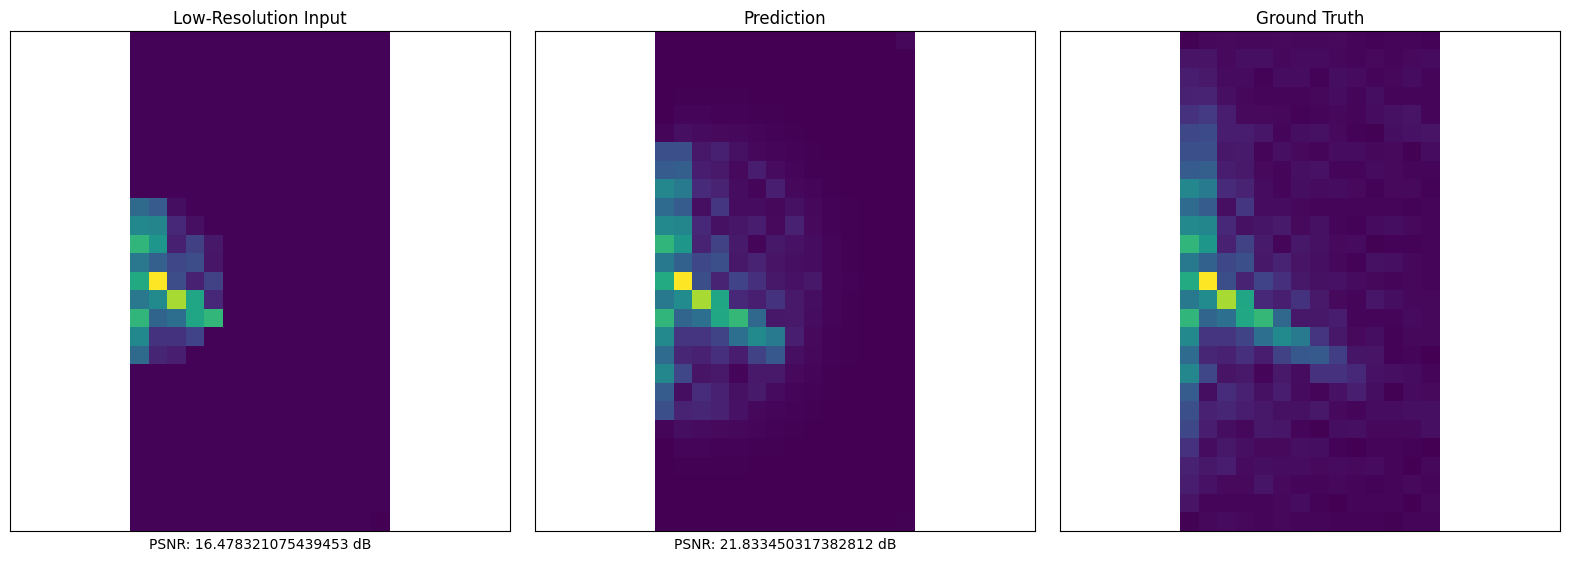

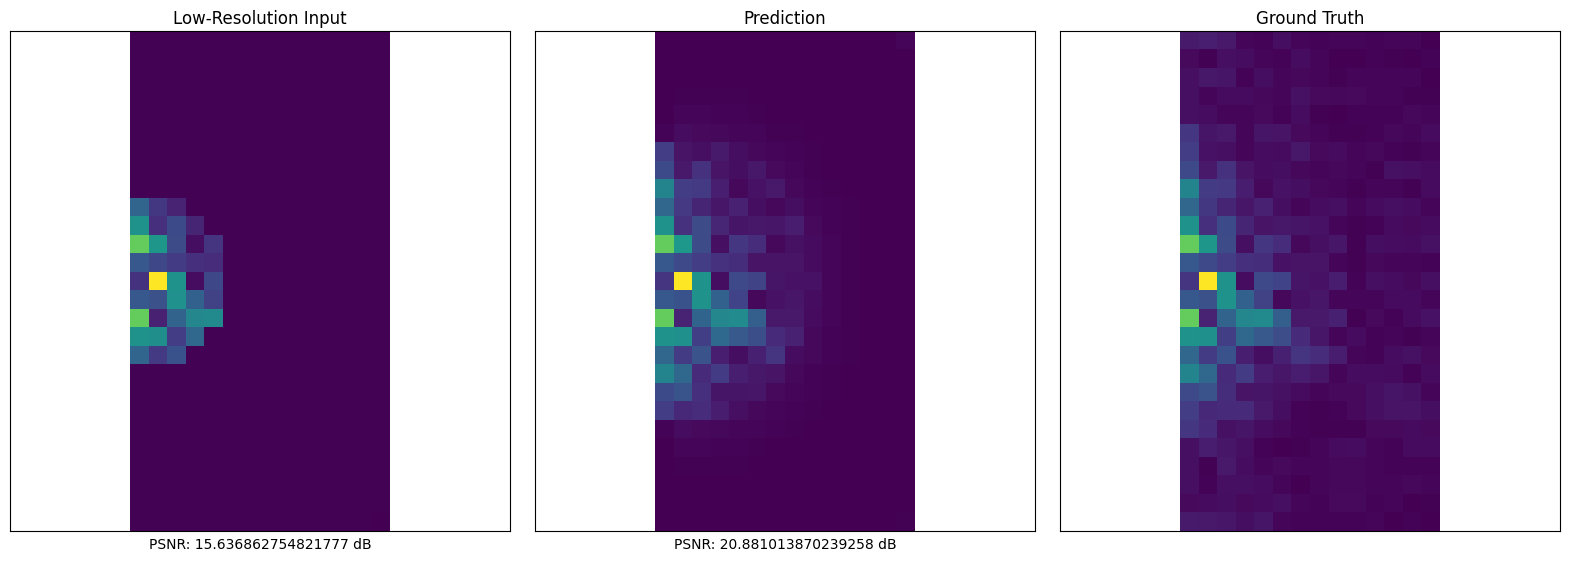

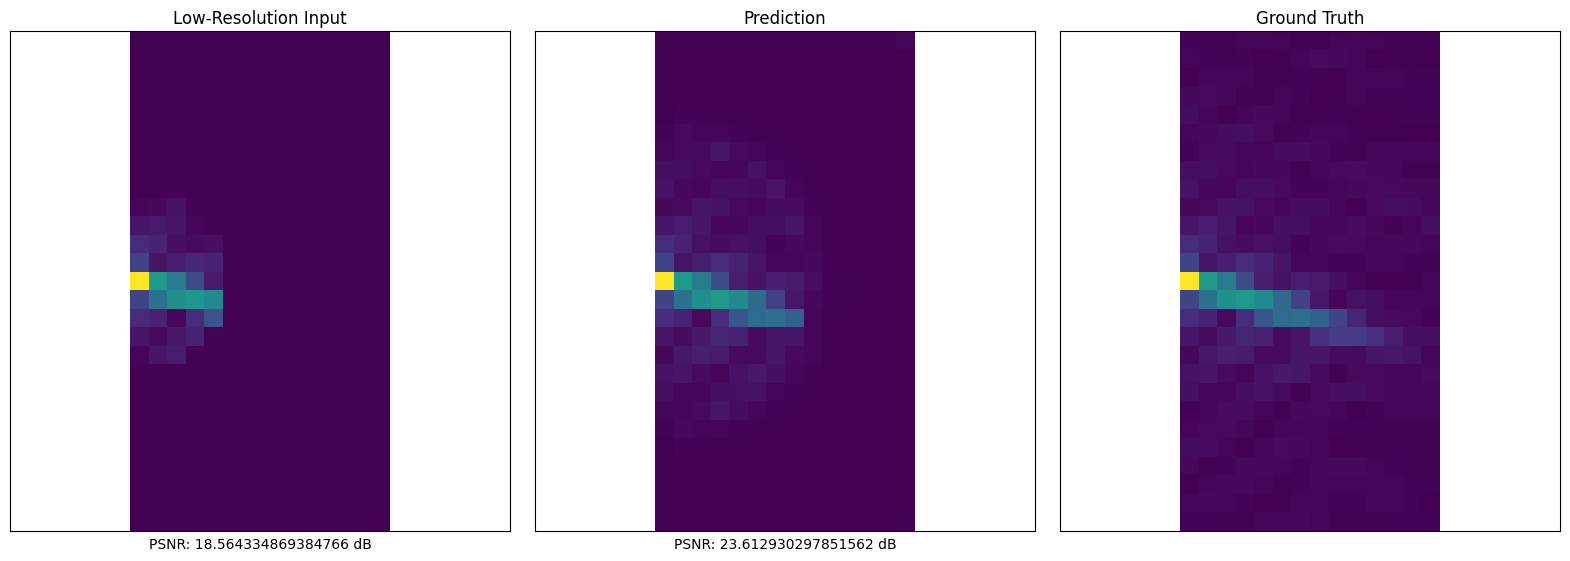

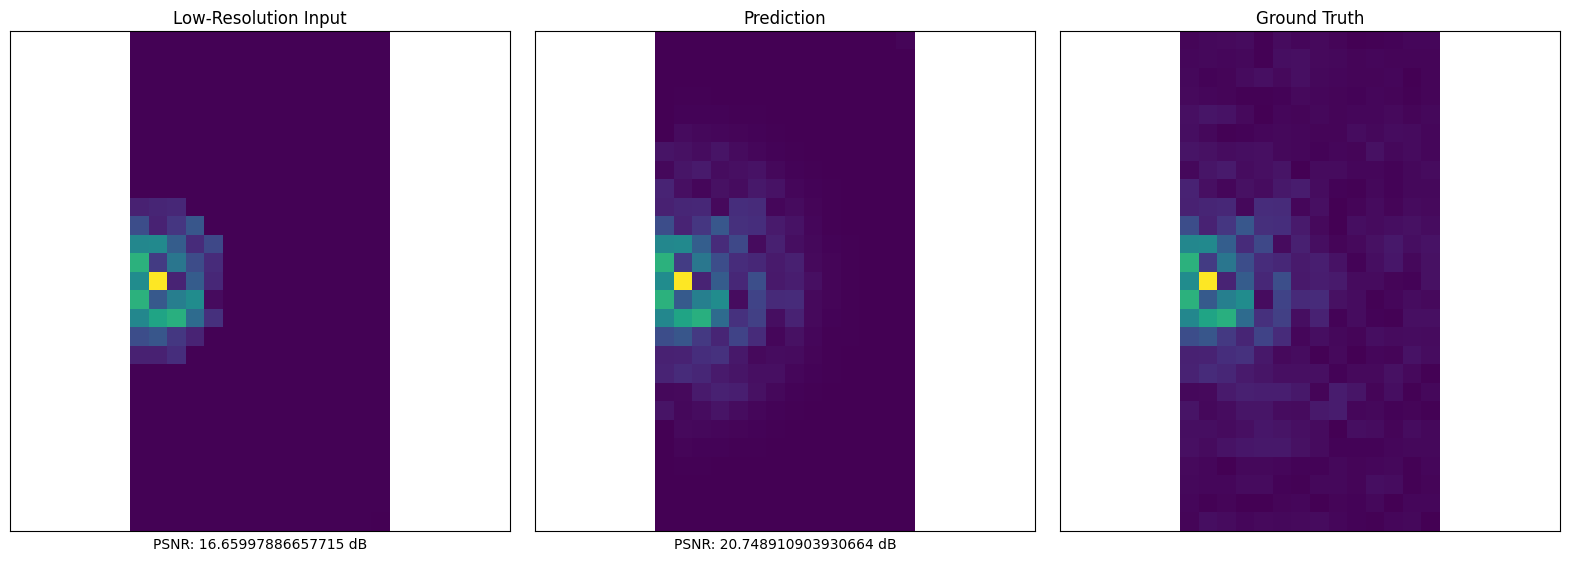

In [24]:
from sklearn.random_projection import sample_without_replacement


diff =[]
for i in range(4):
    sample = i
    # pred_img[i] = (pred_img[i] - gt_img[i].min())/(gt_img[i].max() - gt_img[i].min())
    # lowres_img[i] = (lowres_img[i] - gt_img[i].min())/(gt_img[i].max() - gt_img[i].min())
    fig = plt.figure(figsize=(31/2., 10/2.))
    gs = gridspec.GridSpec(1, 5, width_ratios=[10,0.5, 10, 0.5, 10]) 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[2])
    ax2 = plt.subplot(gs[4])
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                        hspace = 0, wspace = 0)
    ax0.xaxis.set_major_locator(plt.NullLocator())
    ax0.yaxis.set_major_locator(plt.NullLocator())
    lowres_psnr = PSNR(gt_img, lowres_img)
    # lowres_img_vs_gt_img_psnr = PSNR(gt_img[sample].cpu()[2:, 2:], lowres_img[sample].cpu()[2:, 2:], drange=torch.tensor(255., dtype=torch.float32))
    ax0.imshow(np.roll(abs(torch.fft.rfftn(lowres_img[sample].cpu(),dim = [0,1])),13,0))
    ax0.set_title('Low-Resolution Input');
    ax0.set_xlabel(f'PSNR: {lowres_psnr[sample].cpu().detach()} dB')
    ax0.axis('equal');

    ax1.xaxis.set_major_locator(plt.NullLocator())
    ax1.yaxis.set_major_locator(plt.NullLocator())
    ax1.imshow(np.roll(abs(torch.fft.rfftn(pred_img[sample].cpu(),dim = [0,1])),13,0))
    pred_psnr = PSNR(gt_img, pred_img)
    # pred_vs_gt_img_psnr = PSNR(gt_img[sample].cpu()[2:, 2:], pred_img[sample].cpu()[2:, 2:], drange=torch.tensor(255., dtype=torch.float32))
    ax1.set_title('Prediction');
    ax1.set_xlabel(f'PSNR: {pred_psnr[sample].cpu().detach()} dB')
    ax1.axis('equal');

    ax2.xaxis.set_major_locator(plt.NullLocator())
    ax2.yaxis.set_major_locator(plt.NullLocator())
    ax2.imshow(np.roll(abs(torch.fft.rfftn(gt_img[sample].cpu(),dim = [0,1])),13,0))
    ax2.set_title('Ground Truth');
    # ax2.set_xlabel(f'Max: {gt_img[sample].cpu().max():.2f} Min: {gt_img[sample].cpu().min():.2f}');
    ax2.axis('equal');
    diff.append(lowres_psnr - pred_psnr)

In [47]:
lowres_psnr.shape

torch.Size([32])

In [18]:
a[:,0].min()

2.4682674

In [19]:
a[:,13].max()


2.4682736

In [27]:
import seaborn as sns

<Axes: >

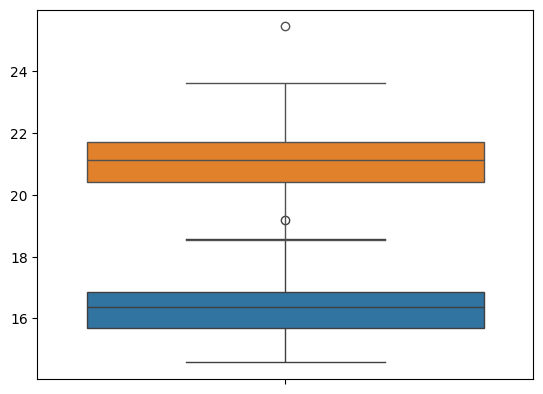

In [28]:
sns.boxplot(lowres_psnr.cpu().detach().numpy())
sns.boxplot(pred_psnr.cpu().detach().numpy())